In [11]:
import pandas as pd
import os
import librosa
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, StratifiedKFold
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l2
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE 
from sklearn.preprocessing import LabelEncoder


In [12]:
# early stopping
# uni / bidirectional
# outros parametros
# multi head attention? 
# CNN-BiLSTMb


In [13]:
data = np.load('UrbanSound8K_features.npz')
features = data['features']
labels = data['labels']
folds = data['folds']
print(features[0].shape)
print(features[:5])

(142, 174)
[[[-332.03875732 -169.5877533   -90.24684143 ...    0.
      0.            0.        ]
  [ 119.39659119   83.29504395   61.68871307 ...    0.
      0.            0.        ]
  [-102.8757782  -120.09382629 -129.49960327 ...    0.
      0.            0.        ]
  ...
  [ -48.18417358  -30.24951744  -19.46636581 ...    0.
      0.            0.        ]
  [ -49.27916718  -31.00568008  -23.53400421 ...    0.
      0.            0.        ]
  [ -55.39807892  -43.50879669  -35.68670273 ...    0.
      0.            0.        ]]

 [[-486.05615234 -447.30462646 -441.84771729 ... -419.9012146
   -434.79315186    0.        ]
  [  90.49243927   98.96133423   98.7935791  ...   73.74655151
     73.07428741    0.        ]
  [ -16.82030487  -12.40661049  -15.04248238 ...  -28.1361351
    -29.96854019    0.        ]
  ...
  [ -58.08222961  -55.15785217  -53.19246674 ...  -54.42551041
    -55.79910278    0.        ]
  [ -60.8597641   -56.75440216  -53.92406845 ...  -53.93930817
    -55.2657

In [14]:
print(features[1].shape)
print(labels[13])
print(folds.shape)

(142, 174)
1
(8732,)


In [15]:
# Compute mean and standard deviation for each MFCC across all time steps and samples
mean = np.mean(features, axis=(0, 1), keepdims=True)  # Mean of each MFCC
std = np.std(features, axis=(0, 1), keepdims=True)    # Standard deviation of each MFCC

# Normalize the features
normalized_features = (features - mean) / std

# Print the shape and check if it worked (first sample)
print(normalized_features.shape)  # Should be the same as 'features' (num_samples, time_steps, n_mfcc)
print(normalized_features[0])  # Check the normalized features for the first sample

(8732, 142, 174)
[[-9.54278659 -4.88003743 -2.33639455 ...  0.55584363  0.58280508
   0.01392185]
 [ 4.3707784   3.33386528  2.63232821 ...  0.55584363  0.58280508
   0.01392185]
 [-2.4798173  -3.27242195 -3.62007099 ...  0.55584363  0.58280508
   0.01392185]
 ...
 [-0.79418236 -0.35418306 -0.02167262 ...  0.55584363  0.58280508
   0.01392185]
 [-0.82793086 -0.37874403 -0.15469591 ...  0.55584363  0.58280508
   0.01392185]
 [-1.01652016 -0.78485858 -0.55212356 ...  0.55584363  0.58280508
   0.01392185]]


In [16]:
print(features.shape)

(8732, 142, 174)


In [17]:
# Assuming 'labels' contains the class labels and 'folds' contains the fold assignments
# Count the number of samples per class
classes, counts = np.unique(labels, return_counts=True)

# Display the overall class distribution
print("Overall Class distribution:")
for class_id, count in zip(classes, counts):
    print(f"Class {class_id}: {count} samples")

# Display the class distribution per fold
print("\nClass distribution per fold:")
for fold in np.unique(folds):
    print(f"\nFold {fold}:")
    
    # Get the indices for the current fold
    fold_indices = np.where(folds == fold)[0]
    
    # Get the class labels for the samples in the current fold
    fold_labels = labels[fold_indices]
    
    # Count the number of samples per class for the current fold
    fold_classes, fold_counts = np.unique(fold_labels, return_counts=True)
    
    for class_id, count in zip(fold_classes, fold_counts):
        print(f"  Class {class_id}: {count} samples")

Overall Class distribution:
Class 0: 1000 samples
Class 1: 429 samples
Class 2: 1000 samples
Class 3: 1000 samples
Class 4: 1000 samples
Class 5: 1000 samples
Class 6: 374 samples
Class 7: 1000 samples
Class 8: 929 samples
Class 9: 1000 samples

Class distribution per fold:

Fold 1:
  Class 0: 100 samples
  Class 1: 36 samples
  Class 2: 100 samples
  Class 3: 100 samples
  Class 4: 100 samples
  Class 5: 96 samples
  Class 6: 35 samples
  Class 7: 120 samples
  Class 8: 86 samples
  Class 9: 100 samples

Fold 2:
  Class 0: 100 samples
  Class 1: 42 samples
  Class 2: 100 samples
  Class 3: 100 samples
  Class 4: 100 samples
  Class 5: 100 samples
  Class 6: 35 samples
  Class 7: 120 samples
  Class 8: 91 samples
  Class 9: 100 samples

Fold 3:
  Class 0: 100 samples
  Class 1: 43 samples
  Class 2: 100 samples
  Class 3: 100 samples
  Class 4: 100 samples
  Class 5: 107 samples
  Class 6: 36 samples
  Class 7: 120 samples
  Class 8: 119 samples
  Class 9: 100 samples

Fold 4:
  Class 

In [18]:
def create_bidirectional_lstm_model(input_shape=(142,174), units=128, dropout_rate=0.3, l2_reg=0.001):
    model = Sequential()
    
    # First Bidirectional LSTM layer with L2 regularization
    model.add(Bidirectional(LSTM(units, return_sequences=True, kernel_regularizer=l2(l2_reg)), input_shape=input_shape))
    model.add(Dropout(dropout_rate))

    # First Bidirectional LSTM layer with L2 regularization
    model.add(Bidirectional(LSTM(units // 2, return_sequences=True, kernel_regularizer=l2(l2_reg)), input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    
    # Second Bidirectional LSTM layer with L2 regularization
    model.add(Bidirectional(LSTM(units // 4, return_sequences=False, kernel_regularizer=l2(l2_reg)), input_shape = input_shape))
    model.add(Dropout(dropout_rate))
    
    # Dense layer with L2 regularization
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(l2_reg)))
    model.add(Dropout(dropout_rate))
    
    # Output layer for multi-class classification
    model.add(Dense(10, activation='softmax'))  # Adjust '10' to the number of classes in your dataset

    return model

In [19]:
#labels = to_categorical(labels, num_classes=10)  # Adjust 10 to match your number of classes

In [20]:
# Define the folds
test_fold = 1  # Fold 1 for testing
val_fold = 2 # Fold 2 for validation
train_folds = [i for i in range(1, 11) if i != test_fold and i != val_fold]

# Select data based on fold
train_indices = np.isin(folds, train_folds)
val_indices = folds == val_fold
test_indices = folds == test_fold

# Split the features and labels for training, validation, and test sets
X_train = features[train_indices]
y_train = labels[train_indices]
X_val = features[val_indices]
y_val = labels[val_indices]
X_test = features[test_indices]
y_test = labels[test_indices]

# One-hot encode the labels for validation and test sets
y_val = to_categorical(y_val, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# Apply SMOTE to the training set (only on training data)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train.reshape(X_train.shape[0], -1), y_train)

# Reshape back to the original shape for LSTM (num_samples, time_steps, num_features)
X_train_resampled = X_train_resampled.reshape(X_train_resampled.shape[0], X_train.shape[1], X_train.shape[2])

# One-hot encode the resampled labels
y_train_resampled = to_categorical(y_train_resampled, num_classes=10)

# Check the shape of resampled data to ensure it looks correct
print(f"Resampled X_train shape: {X_train_resampled.shape}")
print(f"Resampled y_train shape: {y_train_resampled.shape}")

# Create and compile the model
model = create_bidirectional_lstm_model()    
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Set up early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train_resampled, y_train_resampled,
                    validation_data=(X_val, y_val),
                    epochs=30,
                    batch_size=128,
                    callbacks=[early_stopping],
                    verbose=1)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc}, Test loss: {test_loss}")


Resampled X_train shape: (8040, 142, 174)
Resampled y_train shape: (8040, 10)


/opt/anaconda3/envs/RNN/lib/python3.11/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 325ms/step - accuracy: 0.2251 - loss: 3.3219 - val_accuracy: 0.3446 - val_loss: 2.4655
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 356ms/step - accuracy: 0.3869 - loss: 2.4477 - val_accuracy: 0.3941 - val_loss: 2.2328
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 26s 419ms/step - accuracy: 0.4853 - loss: 2.0931 - val_accuracy: 0.4212 - val_loss: 2.0702
Epoch 4/30
29/63 ━━━━━━━━━━━━━━━━━━━━ 13s 404ms/step - accuracy: 0.5306 - loss: 1.9024

KeyboardInterrupt: 

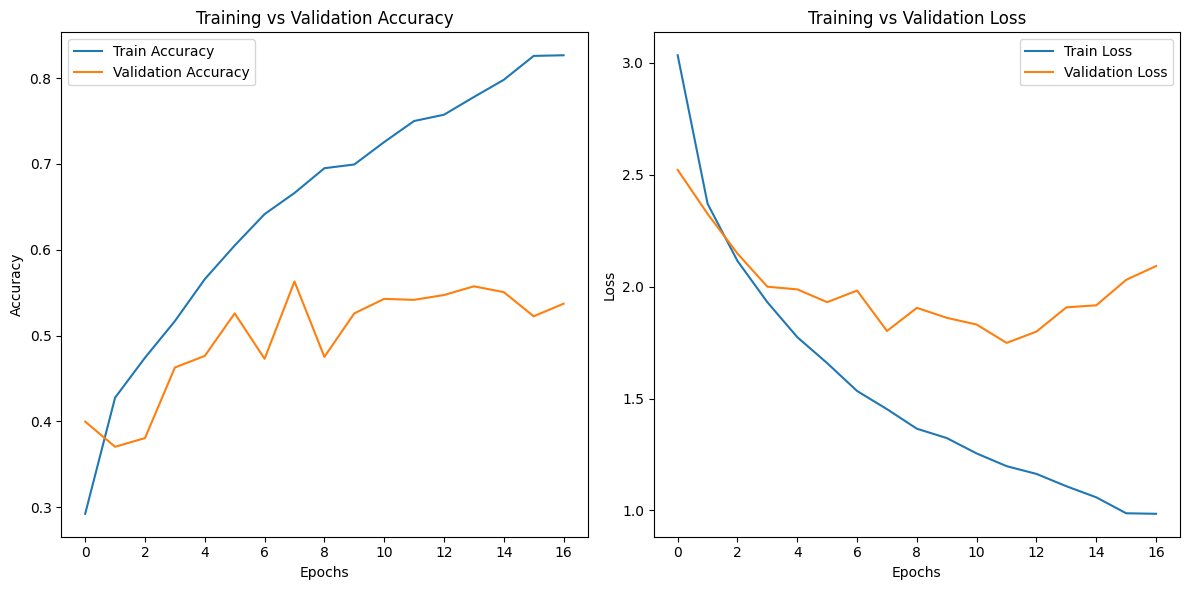

In [185]:

# Extract accuracy and loss from the history object
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plotting training vs validation accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting training vs validation loss
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()


Observations
Training and Validation Accuracy Plot:

Training accuracy steadily increases and reaches around 0.9 by the end of the epochs.
Validation accuracy also improves but plateaus around 0.78–0.8, showing some improvement but not matching training accuracy.
Training and Validation Loss Plot:

Training loss consistently decreases, indicating that the model is learning from the training data.
Validation loss decreases initially but then plateaus and even slightly increases towards the end of the epochs.
Analysis
This pattern indicates overfitting:

The model performs well on the training data (as shown by decreasing training loss and high training accuracy) but struggles to generalize on the validation data.
The gap between training and validation accuracy, combined with the plateauing and slight increase in validation loss, suggests that the model is starting to memorize the training data rather than generalizing.


changes:

- add regularization 
You may need to experiment with different values for l2_reg:

Try values like 0.0001, 0.001, and 0.01 to see which provides the best balance between preventing overfitting and maintaining accuracy.

- add one more layer


ajust parameters (like epochs and learning rate)

add class weights for unrepresented classes

increase mfccc


